<a href="https://www.kaggle.com/code/kaushalsethia/final-copy-project?scriptVersionId=123269391" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt

import cv2
from tqdm import tqdm
import io
import seaborn as sns

from sklearn.utils import shuffle # Shuffle arrays or sparse matrices in a consistent way
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.applications import DenseNet121
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard,ModelCheckpoint

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from keras.utils.vis_utils import plot_model

import ipywidgets as widgets
from PIL import Image
from IPython.display import display, clear_output

In [2]:
import warnings
warnings.filterwarnings("ignore")

## Define Labels

In [3]:
labels = ['Final AD JPEG','Final CN JPEG', 'Final EMCI JPEG', 'Final LMCI JPEG','Final MCI JPEG']

In [4]:
X_train = [] #Training Dataset
Y_train = [] #Training Labels

image_size=150

for i in labels:
    folderPath = os.path.join('/kaggle/input/alzheimers-adni/Alzheimers-ADNI/', 'train', i)
    for j in tqdm(os.listdir(folderPath)):
        image = cv2.imread(os.path.join(folderPath, j))
        image = cv2.resize(image, (image_size, image_size))
        X_train.append(image)
        Y_train.append(i)
        
        
for i in labels:
    folderPath = os.path.join('/kaggle/input/alzheimers-adni/Alzheimers-ADNI', 'test', i) # Join two or more pathname components
    for j in tqdm(os.listdir(folderPath)):
        image = cv2.imread(os.path.join(folderPath, j))
        image = cv2.resize(image, (image_size, image_size))
        X_train.append(image)
        Y_train.append(i)
        
# converted into array

Xtrain = np.array(X_train)
Ytrain = np.array(Y_train)

100%|██████████| 233/233 [00:00<00:00, 243.83it/s]


In [5]:
Xtrain.shape

(18775, 150, 150, 3)

In [6]:
Ytrain.shape

(18775,)

In [7]:
Xtrain, Ytrain = shuffle(Xtrain, Ytrain, random_state=42)

## Train test split which is divided train dataset and validation dataset

In [8]:
xtrain,xtest, Ytrain,ytest = train_test_split(Xtrain, Ytrain,test_size=0.3, random_state=42)

In [9]:
xtrain.shape

(13142, 150, 150, 3)

In [10]:
Ytrain.shape

(13142,)

In [11]:
xtest.shape

(5633, 150, 150, 3)

In [12]:
ytest.shape

(5633,)

## Converting labels into One hot encoder

In [13]:
ytrain_new = []
ytest_new = []

for i in Ytrain:
    ytrain_new.append(labels.index(i))#Converting String Label to integer i.e
                                       
ytrain = to_categorical(ytrain_new) #Converts a class vector (integers) to binary class matrix

for i in ytest:
    ytest_new.append(labels.index(i))

ytest = to_categorical(ytest_new)

In [14]:
ytrain.shape

(13142, 5)

In [15]:
ytest.shape

(5633, 5)

# DENSENET MODEL

In [16]:
model_d=DenseNet121(weights='imagenet',include_top=False, input_shape=(image_size, image_size, 3)) 

29084464/29084464 [==============================] - 0s 0us/step


In [17]:
# Output of model

model = model_d.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(0.5)(model)
model = tf.keras.layers.Dense(5, activation='softmax')(model)
model = tf.keras.models.Model(inputs=model_d.input, outputs=model)

In [18]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc')
]

In [19]:
model.compile( optimizer='adam',
    loss='categorical_crossentropy',
    metrics=METRICS)

In [20]:
history = model.load_weights('/kaggle/input/model-training/Model Training/densenet.h5')

In [21]:
pred = model.predict(xtest)
pred = np.argmax(pred, axis=1)
actual_label = np.argmax(ytest, axis=1)
print(classification_report(actual_label, pred))

177/177 [==============================] - 13s 29ms/step
              precision    recall  f1-score   support

           0       0.99      0.93      0.96      2481
           1       0.94      0.98      0.96      2603
           2       0.57      0.78      0.66       130
           3       0.78      0.65      0.71        43
           4       0.83      0.76      0.80       376

    accuracy                           0.94      5633
   macro avg       0.82      0.82      0.82      5633
weighted avg       0.94      0.94      0.94      5633



In [22]:
accuracy_score(actual_label, pred)

0.938398721817859

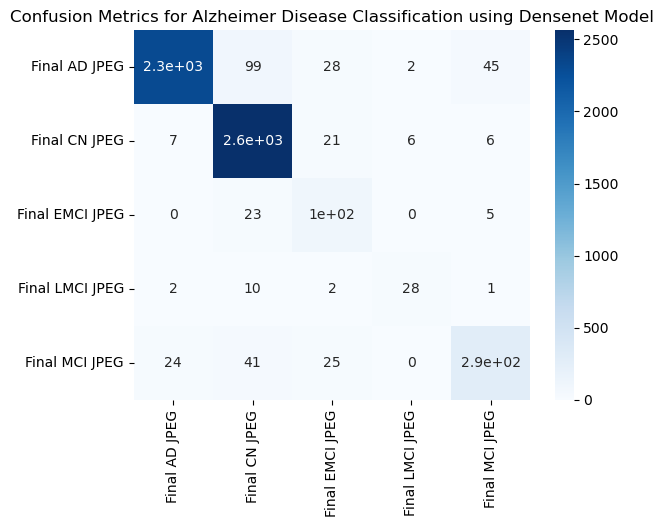

In [23]:
Cm=confusion_matrix(actual_label,pred)
ax=plt.axes()
sns.heatmap(Cm, cmap='Blues' ,annot=True,
           annot_kws={'size':10},
           xticklabels=labels,
           yticklabels=labels,
           ax=ax
           )

plt.title("Confusion Metrics for Alzheimer Disease Classification using Densenet Model")
plt.savefig('densenet_confusion.png', dpi=300) # Save plot as PNG
plt.show()

## Loss and Accuracy Measurement graph

In [24]:
import pickle

with open('/kaggle/input/model-training/Model Training/densenet_history.pkl', 'rb') as f:
    history = pickle.load(f)

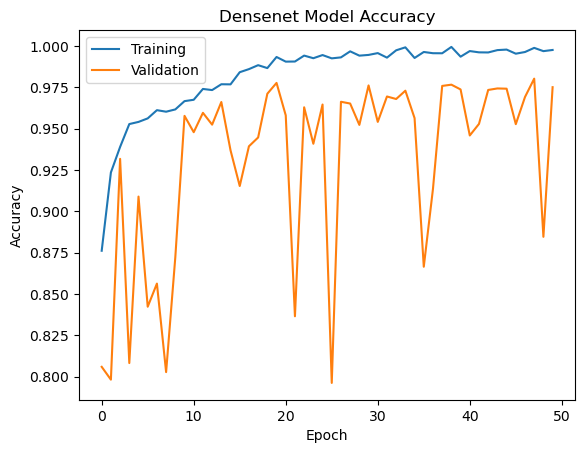

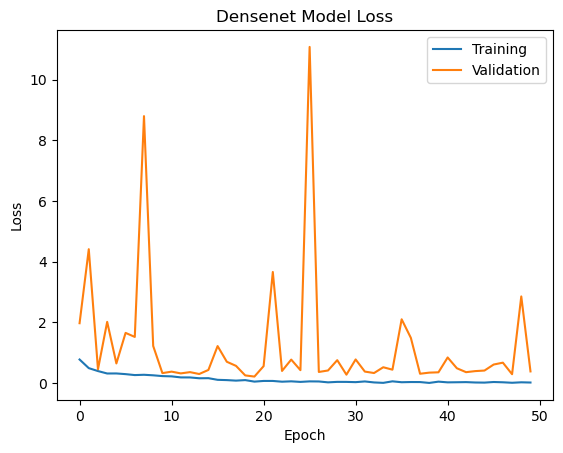

In [25]:
# Plot the training and validation accuracy
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('Densenet Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training', 'Validation'])
plt.savefig('densenet_accuracy.png', dpi=300) # Save plot as PNG
plt.show()

# Plot the training and validation loss
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Densenet Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training', 'Validation'])
plt.savefig('densenet_loss.png', dpi=300) # Save plot as PNG
plt.show()

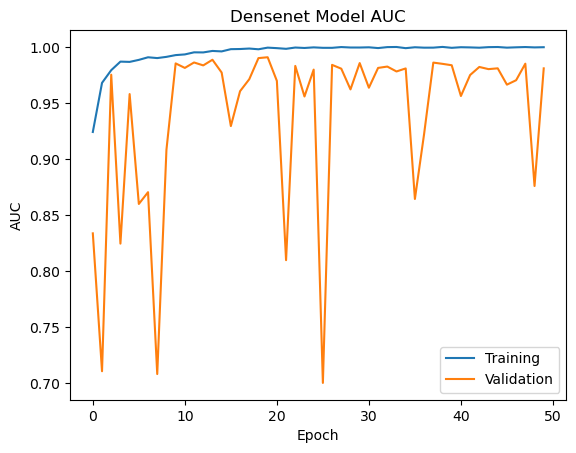

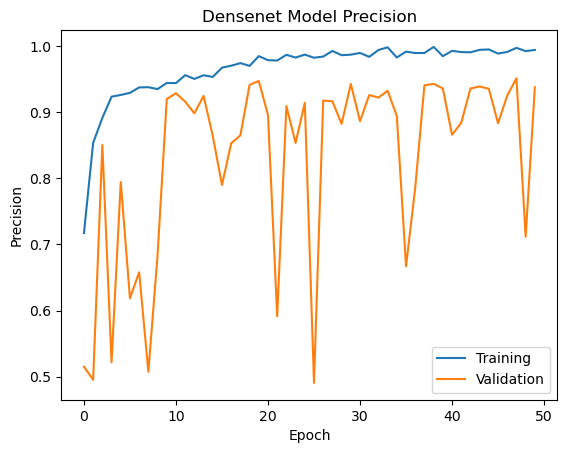

In [26]:
# Plot the training and validation auc
plt.plot(history['auc'])
plt.plot(history['val_auc'])
plt.title('Densenet Model AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend(['Training', 'Validation'])
plt.savefig('densenet_auc.png', dpi=300) # Save plot as PNG
plt.show()

# Plot the training and validation precision
plt.plot(history['precision'])
plt.plot(history['val_precision'])
plt.title('Densenet Model Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend(['Training', 'Validation'])
plt.savefig('densenet_precision.png', dpi=300) # Save plot as PNG
plt.show()

## Making single prediction  using Densenet Model

In [27]:
def imagePrediction(upload):
    for name, fileinfo  in uploader.value.items():
        image = Image.open(io.BytesIO(fileinfo['content']))
        
    images = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)
    images = cv2.resize(images,(150, 150))
    images = images.reshape(1, 150, 150, 3)
    prd = model.predict(images)
    prd = np.argmax(prd, axis = 1)[0]
    
    
    if prd == 0:
        prd = "Final AD JPEG"
    elif prd == 1:
        prd = "Final CN JPEG"
    elif prd ==2:
        prd = "Final EMCI JPEG"
    elif prd ==3:
        prd = "Final LMCI JPEG"
    elif prd ==4:
        prd = "Final MCI JPEG"
        
    print(f'Model Predict That is  a {prd}')
    
   

In [28]:
import ipywidgets as widgets
from IPython.display import display

In [29]:
uploader = widgets.FileUpload()
display(uploader)

FileUpload(value={}, description='Upload')

In [30]:
button = widgets.Button(description= "Predict")
out = widgets.Output()

def on_button_click(_):
    with out:
        clear_output()
        try:
            imagePrediction(uploader)
        except:
            print("Please Enter the Correct Image files")
            
            
button.on_click(on_button_click)
widgets.VBox([button, out])


## CNN MODEL

In [31]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras import layers

model1 = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(image_size, image_size, 3)),
    MaxPooling2D((2,2)),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(5, activation='softmax')
])

In [32]:
model1.compile( optimizer='adam',
    loss='categorical_crossentropy',
    metrics=METRICS)

In [33]:
history1 = model1.load_weights('/kaggle/input/model-training/Model Training/cnn.h5')


In [34]:
ev1 = model1.predict(xtest)

177/177 [==============================] - 1s 5ms/step


In [35]:
pred1 = model1.predict(xtest)
pred1 = np.argmax(pred1, axis=1)
actual_label1 = np.argmax(ytest, axis=1)
print(classification_report(actual_label1, pred1))

177/177 [==============================] - 1s 4ms/step
              precision    recall  f1-score   support

           0       0.95      0.89      0.92      2481
           1       0.89      0.97      0.93      2603
           2       0.77      0.63      0.69       130
           3       1.00      0.65      0.79        43
           4       0.86      0.71      0.78       376

    accuracy                           0.91      5633
   macro avg       0.89      0.77      0.82      5633
weighted avg       0.91      0.91      0.91      5633



In [36]:
accuracy_score(actual_label1, pred1)

0.9098171489437245

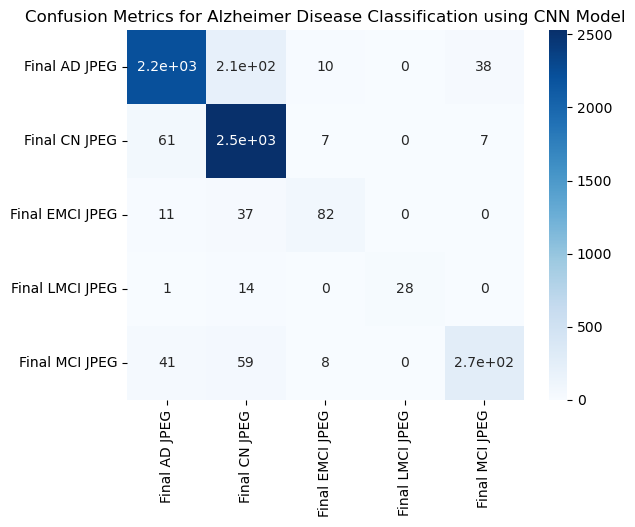

In [37]:
Cm1=confusion_matrix(actual_label1,pred1)
ax1=plt.axes()
sns.heatmap(Cm1, cmap='Blues' ,annot=True,
           annot_kws={'size':10},
           xticklabels=labels,
           yticklabels=labels,
           ax=ax1
           )

plt.title("Confusion Metrics for Alzheimer Disease Classification using CNN Model")
plt.savefig('cnn_confusion.png', dpi=300) # Save plot as PNG
plt.show()

## Loss and Accuracy Measurement Graph - CNN Model

In [38]:
import pickle

with open('/kaggle/input/model-training/Model Training/cnn_history.pkl', 'rb') as f:
    history1 = pickle.load(f)


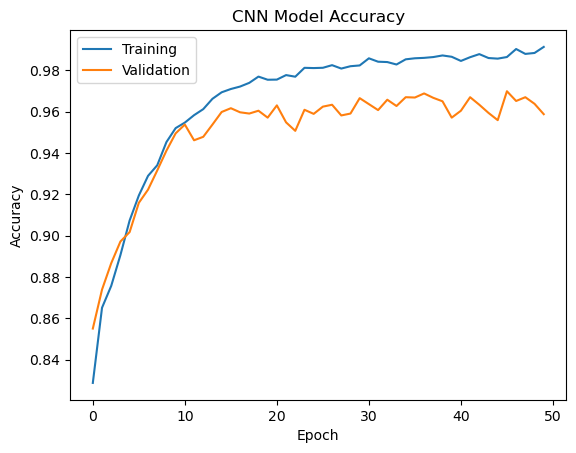

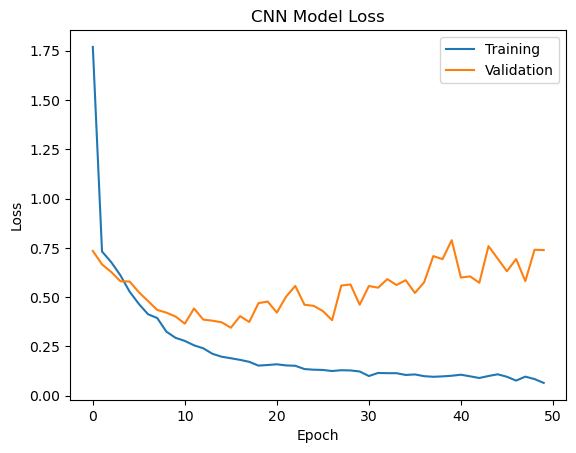

In [39]:
# Plot the training and validation accuracy
plt.plot(history1['accuracy'])
plt.plot(history1['val_accuracy'])
plt.title('CNN Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training', 'Validation'])
plt.savefig('cnn_accuracy.png', dpi=300) # Save plot as PNG
plt.show()

# Plot the training and validation loss
plt.plot(history1['loss'])
plt.plot(history1['val_loss'])
plt.title('CNN Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training', 'Validation'])
plt.savefig('cnn_loss.png', dpi=300) # Save plot as PNG
plt.show()

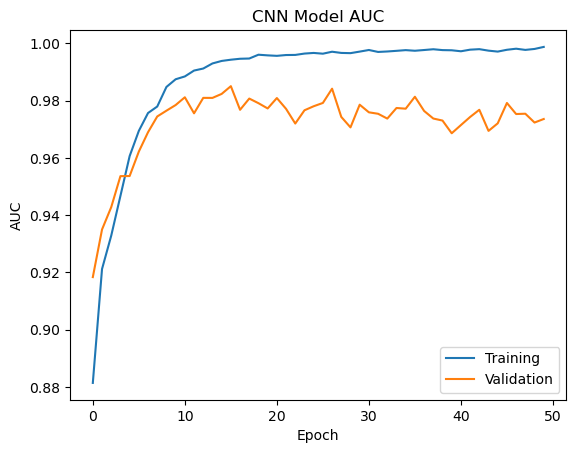

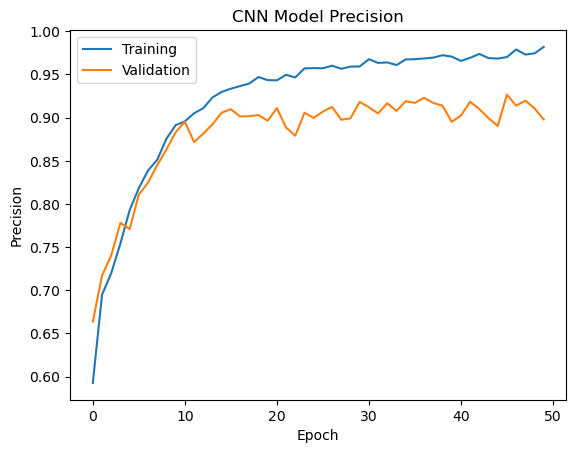

In [40]:
# Plot the training and validation auc
plt.plot(history1['auc'])
plt.plot(history1['val_auc'])
plt.title('CNN Model AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend(['Training', 'Validation'])
plt.savefig('cnn_auc.png', dpi=300) # Save plot as PNG
plt.show()

# Plot the training and validation precision
plt.plot(history1['precision'])
plt.plot(history1['val_precision'])
plt.title('CNN Model Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend(['Training', 'Validation'])
plt.savefig('cnn_precision.png', dpi=300) # Save plot as PNG
plt.show()

## Making single prediction using CNN Model

In [41]:
def imagePrediction(upload):
    for name, fileinfo  in uploader.value.items():
        image = Image.open(io.BytesIO(fileinfo['content']))
        
    images = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)
    images = cv2.resize(images,(150, 150))
    images = images.reshape(1, 150, 150, 3)
    prd = model1.predict(images)
    prd = np.argmax(prd, axis = 1)[0]
    
    
    if prd == 0:
        prd = "Final AD JPEG"
    elif prd == 1:
        prd = "Final CN JPEG"
    elif prd ==2:
        prd = "Final EMCI JPEG"
    elif prd ==3:
        prd = "Final LMCI JPEG"
    elif prd ==4:
        prd = "Final MCI JPEG"
        
    print(f'Model Predict That is  a {prd}')
    
   

In [42]:
uploader = widgets.FileUpload()
display(uploader)

FileUpload(value={}, description='Upload')

In [43]:
button = widgets.Button(description= "Predict")
out = widgets.Output()

def on_button_click(_):
    with out:
        clear_output()
        try:
            imagePrediction(uploader)
        except:
            print("Please Enter the Correct Image files")
            
            
button.on_click(on_button_click)
widgets.VBox([button, out])


## Efficient NetB7 Model

In [44]:
from tensorflow.keras.applications import EfficientNetB7

In [45]:
efficientnetB7= EfficientNetB7(include_top=False,weights='imagenet',input_shape=(image_size, image_size, 3))

258076736/258076736 [==============================] - 1s 0us/step


In [46]:
# Output of model

model2 = efficientnetB7.output
model2 = tf.keras.layers.GlobalAveragePooling2D()(model2)
model2 = tf.keras.layers.Dropout(0.5)(model2)
model2 = tf.keras.layers.Dense(5, activation='softmax')(model2)
model2 = tf.keras.models.Model(inputs=efficientnetB7.input, outputs=model2)

In [47]:
model2.compile( optimizer='adam',
    loss='categorical_crossentropy',
    metrics=METRICS)

In [48]:
history2 = model2.load_weights('/kaggle/input/model-training/Model Training/efficientb7.h5')

In [49]:
import pickle

with open('/kaggle/input/model-training/Model Training/efficientb7_history.pkl', 'rb') as f:
    history2 = pickle.load(f)


In [50]:
ev2 = model2.predict(xtest)

177/177 [==============================] - 27s 122ms/step


In [51]:
pred2 = model2.predict(xtest)
pred2 = np.argmax(pred2, axis=1)
actual_label2 = np.argmax(ytest, axis=1)
print(classification_report(actual_label2, pred2))

177/177 [==============================] - 21s 121ms/step
              precision    recall  f1-score   support

           0       0.96      0.97      0.97      2481
           1       0.97      0.98      0.97      2603
           2       0.77      0.72      0.75       130
           3       0.67      0.65      0.66        43
           4       0.82      0.73      0.77       376

    accuracy                           0.95      5633
   macro avg       0.84      0.81      0.82      5633
weighted avg       0.95      0.95      0.95      5633



In [52]:
accuracy_score(actual_label2, pred2)

0.9515355938221196

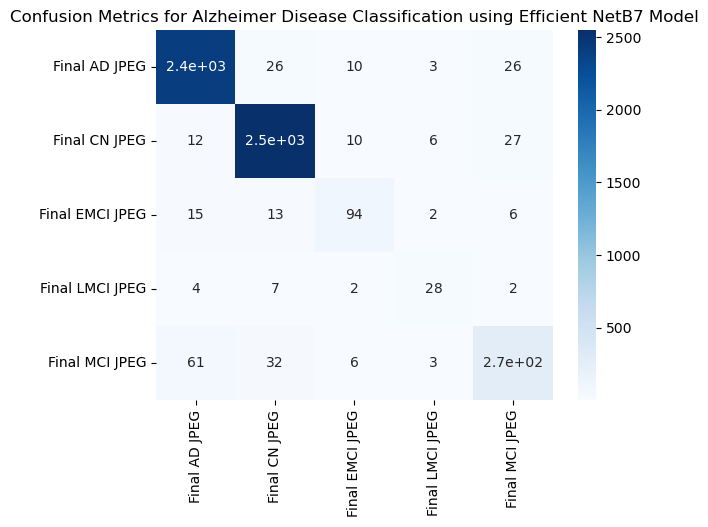

In [53]:
Cm2=confusion_matrix(actual_label2,pred2)
ax2=plt.axes()
sns.heatmap(Cm2, cmap='Blues' ,annot=True,
           annot_kws={'size':10},
           xticklabels=labels,
           yticklabels=labels,
           ax=ax2
           )

plt.title("Confusion Metrics for Alzheimer Disease Classification using Efficient NetB7 Model")
plt.savefig('netb7_confusion.png', dpi=300) # Save plot as PNG
plt.show()

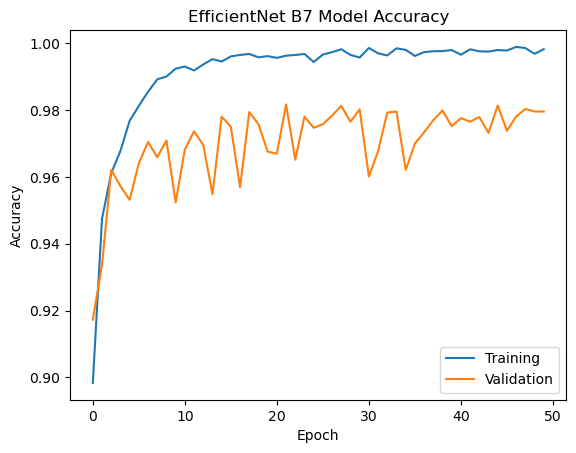

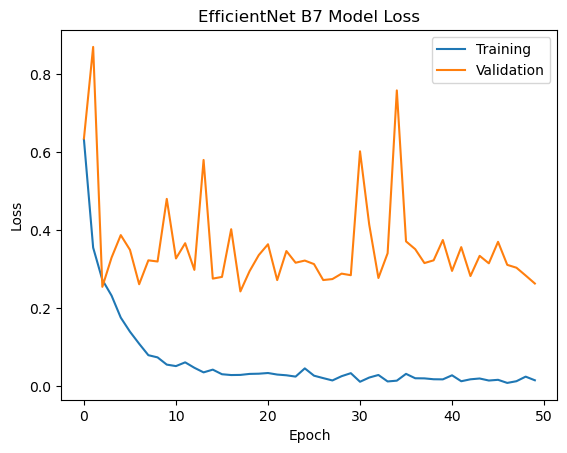

In [54]:
# Plot the training and validation accuracy
plt.plot(history2['accuracy'])
plt.plot(history2['val_accuracy'])
plt.title('EfficientNet B7 Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training', 'Validation'])
plt.savefig('netb7_accuracy.png', dpi=300) # Save plot as PNG
plt.show()

# Plot the training and validation loss
plt.plot(history2['loss'])
plt.plot(history2['val_loss'])
plt.title('EfficientNet B7 Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training', 'Validation'])
plt.savefig('netb7_loss.png', dpi=300) # Save plot as PNG
plt.show()

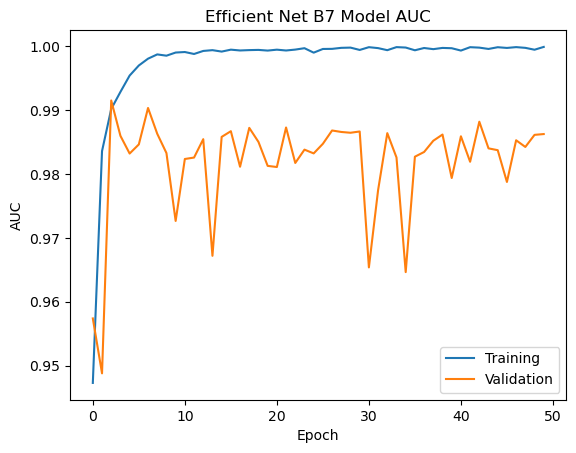

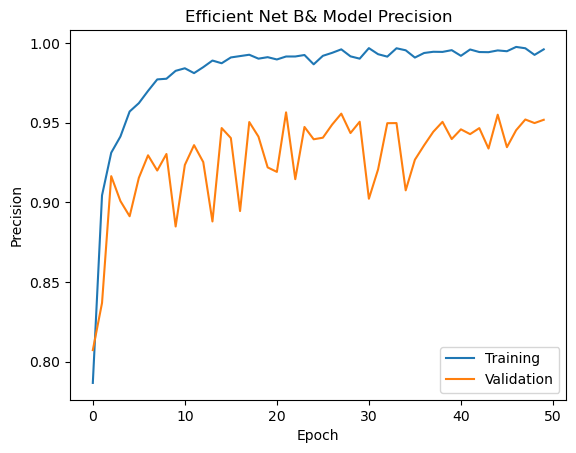

In [55]:
# Plot the training and validation auc
plt.plot(history2['auc'])
plt.plot(history2['val_auc'])
plt.title('Efficient Net B7 Model AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend(['Training', 'Validation'])
plt.savefig('netb7_auc.png', dpi=300) # Save plot as PNG

plt.show()

# Plot the training and validation precision
plt.plot(history2['precision'])
plt.plot(history2['val_precision'])
plt.title('Efficient Net B& Model Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend(['Training', 'Validation'])
plt.savefig('netb7_precision.png', dpi=300) # Save plot as PNG
plt.show()

## Making single prediction using Efficient NetB7 Model

In [56]:
def imagePrediction(upload):
    for name, fileinfo  in uploader.value.items():
        image = Image.open(io.BytesIO(fileinfo['content']))
        
    images = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)
    images = cv2.resize(images,(150, 150))
    images = images.reshape(1, 150, 150, 3)
    prd = model2.predict(images)
    prd = np.argmax(prd, axis = 1)[0]
    
    
    if prd == 0:
        prd = "Final AD JPEG"
    elif prd == 1:
        prd = "Final CN JPEG"
    elif prd ==2:
        prd = "Final EMCI JPEG"
    elif prd ==3:
        prd = "Final LMCI JPEG"
    elif prd ==4:
        prd = "Final MCI JPEG"
        
    print(f'Model Predict That is  a {prd}')
    
   

In [57]:
uploader = widgets.FileUpload()
display(uploader)

FileUpload(value={}, description='Upload')

In [58]:
button = widgets.Button(description= "Predict")
out = widgets.Output()

def on_button_click(_):
    with out:
        clear_output()
        try:
            imagePrediction(uploader)
        except:
            print("Please Enter the Correct Image files")
            
            
button.on_click(on_button_click)
widgets.VBox([button, out])


# VGG19 MODEL

In [59]:
from tensorflow.keras.applications.vgg19 import VGG19
vgg = VGG19(weights='imagenet',
            include_top = False,input_shape=(image_size, image_size, 3)
           )
for layer in vgg.layers:
    layer.trainable = False
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten,Dense
model3 = Sequential()
model3.add(vgg)
model3.add(Flatten())
model3.add(Dense(5,activation="softmax"))
#model.summary()

80134624/80134624 [==============================] - 0s 0us/step


## Compile VGG19 Model

In [60]:
model3.compile( optimizer='adam',
    loss='categorical_crossentropy',
    metrics=METRICS)

In [61]:
history3 = model3.load_weights('/kaggle/input/model-training/Model Training/vgg19.h5')

In [62]:
import pickle

with open('/kaggle/input/model-training/Model Training/vgg19_history.pkl', 'rb') as f:
    history3 = pickle.load(f)


In [63]:
ev3 = model3.predict(xtest)

177/177 [==============================] - 8s 38ms/step


In [64]:
pred3 = model3.predict(xtest)
pred3 = np.argmax(pred3, axis=1)
actual_label3 = np.argmax(ytest, axis=1)
print(classification_report(actual_label3, pred3, target_names=labels))

177/177 [==============================] - 7s 37ms/step
                 precision    recall  f1-score   support

  Final AD JPEG       0.80      0.95      0.87      2481
  Final CN JPEG       0.94      0.82      0.88      2603
Final EMCI JPEG       0.74      0.62      0.67       130
Final LMCI JPEG       0.67      0.65      0.66        43
 Final MCI JPEG       0.83      0.57      0.68       376

       accuracy                           0.86      5633
      macro avg       0.80      0.72      0.75      5633
   weighted avg       0.86      0.86      0.85      5633



In [65]:
accuracy_score(actual_label3, pred3)

0.8554944079531334

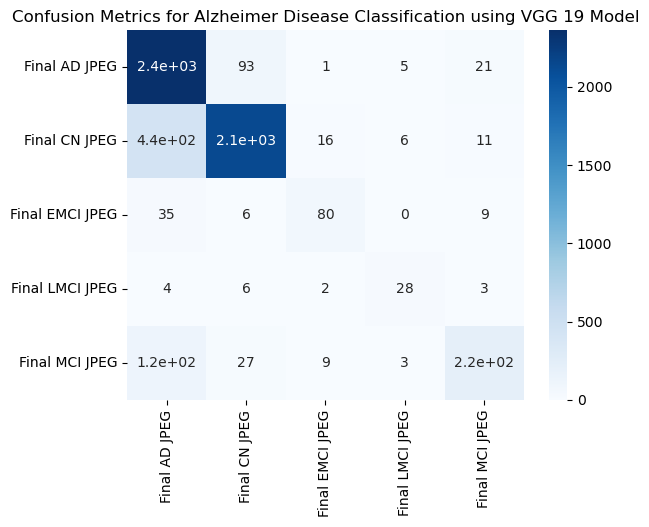

In [66]:
Cm3=confusion_matrix(actual_label3,pred3)
ax3=plt.axes()
sns.heatmap(Cm3, cmap='Blues' ,annot=True,
           annot_kws={'size':10},
           xticklabels=labels,
           yticklabels=labels,
           ax=ax3
           )

plt.title("Confusion Metrics for Alzheimer Disease Classification using VGG 19 Model")
plt.savefig('vgg19_confusion.png', dpi=300) # Save plot as PNG
plt.show()

## Loss and Accuracy Measurement Graph - VGG19 Model

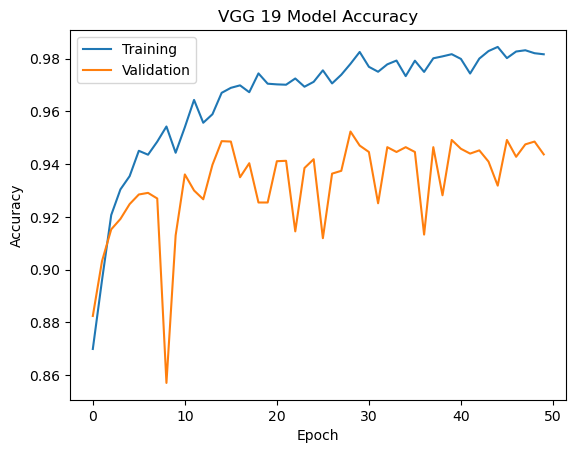

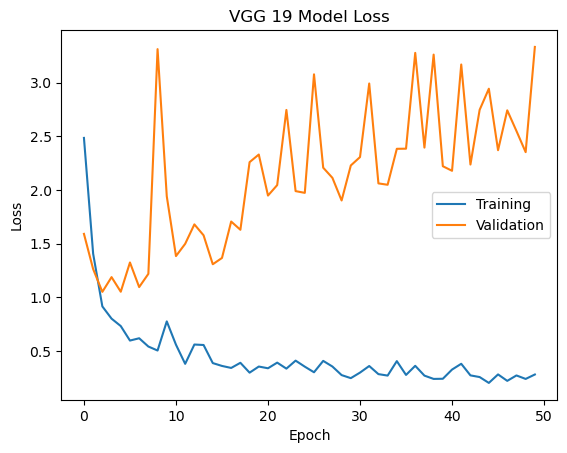

In [67]:
# Plot the training and validation accuracy
plt.plot(history3['accuracy'])
plt.plot(history3['val_accuracy'])
plt.title('VGG 19 Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training', 'Validation'])
plt.savefig('vgg19_accuracy.png', dpi=300) # Save plot as PNG
plt.show()

# Plot the training and validation loss
plt.plot(history3['loss'])
plt.plot(history3['val_loss'])
plt.title('VGG 19 Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training', 'Validation'])
plt.savefig('vgg19_loss.png', dpi=300) # Save plot as PNG
plt.show()

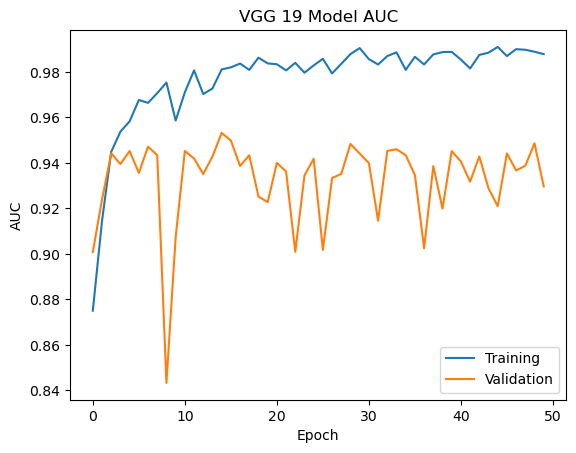

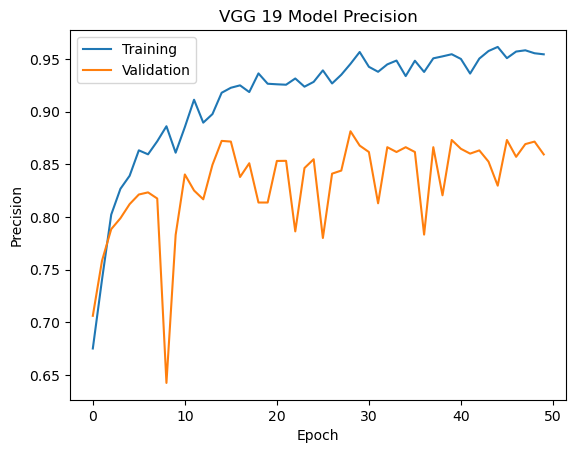

In [68]:
# Plot the training and validation auc
plt.plot(history3['auc'])
plt.plot(history3['val_auc'])
plt.title('VGG 19 Model AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend(['Training', 'Validation'])
plt.savefig('vgg19_auc.png', dpi=300) # Save plot as PNG
plt.show()

# Plot the training and validation precision
plt.plot(history3['precision'])
plt.plot(history3['val_precision'])
plt.title('VGG 19 Model Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend(['Training', 'Validation'])
plt.savefig('vgg19_precision.png', dpi=300) # Save plot as PNG
plt.show()

## Making single prediction using VGG19 Model

In [69]:
def imagePrediction(upload):
    for name, fileinfo  in uploader.value.items():
        image = Image.open(io.BytesIO(fileinfo['content']))
        
    images = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)
    images = cv2.resize(images,(150, 150))
    images = images.reshape(1, 150, 150, 3)
    prd = model3.predict(images)
    prd = np.argmax(prd, axis = 1)[0]
    
    
    if prd == 0:
        prd = "Final AD JPEG"
    elif prd == 1:
        prd = "Final CN JPEG"
    elif prd ==2:
        prd = "Final EMCI JPEG"
    elif prd ==3:
        prd = "Final LMCI JPEG"
    elif prd ==4:
        prd = "Final MCI JPEG"
        
    print(f'Model Predict That is  a {prd}')
    
   

In [70]:
uploader = widgets.FileUpload()
display(uploader)

FileUpload(value={}, description='Upload')

## Making single prediction using VGG19 Model

In [71]:
button = widgets.Button(description= "Predict")
out = widgets.Output()

def on_button_click(_):
    with out:
        clear_output()
        try:
            imagePrediction(uploader)
        except:
            print("Please Enter the Correct Image files")
            
            
button.on_click(on_button_click)
widgets.VBox([button, out])


## Comparison and Graphs of Different Model Types

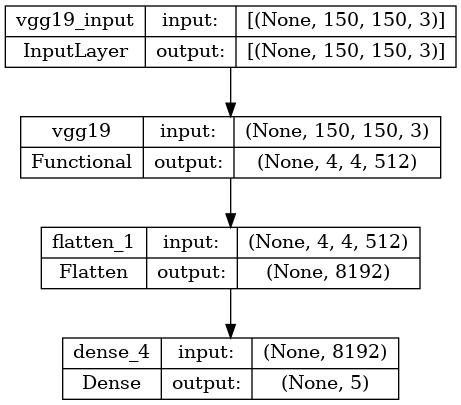

In [72]:
plot_model(model3, to_file='/kaggle/working/vgg_model.png', show_shapes=True, show_layer_names=True)


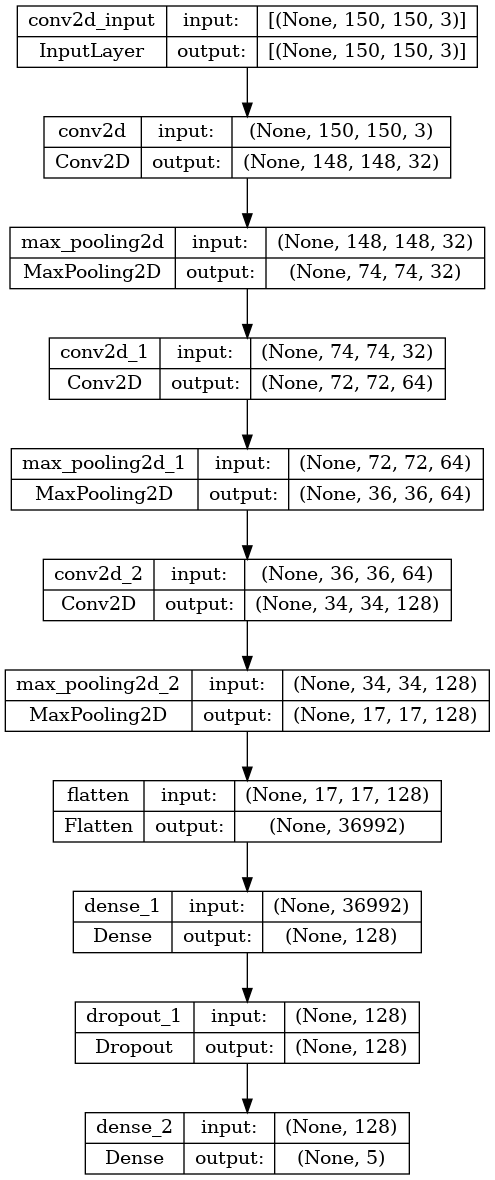

In [73]:
plot_model(model1, to_file='/kaggle/working/cnn_model.png', show_shapes=True, show_layer_names=True)


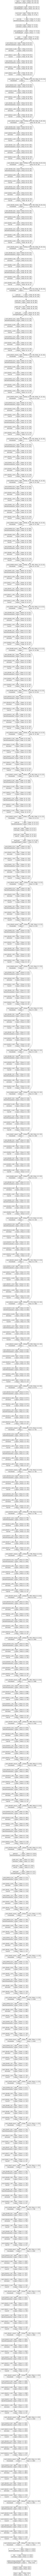

In [74]:
plot_model(model, to_file='/kaggle/working/densenet_model.png', show_shapes=True, show_layer_names=True)


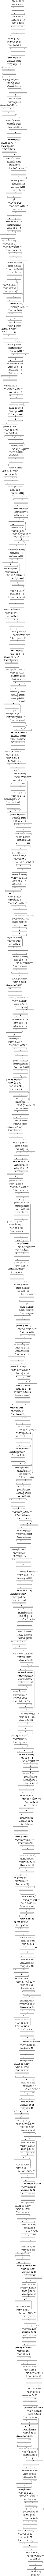

In [75]:
plot_model(model2, to_file='/kaggle/working/efficientnetb7_model.png', show_shapes=True, show_layer_names=True)


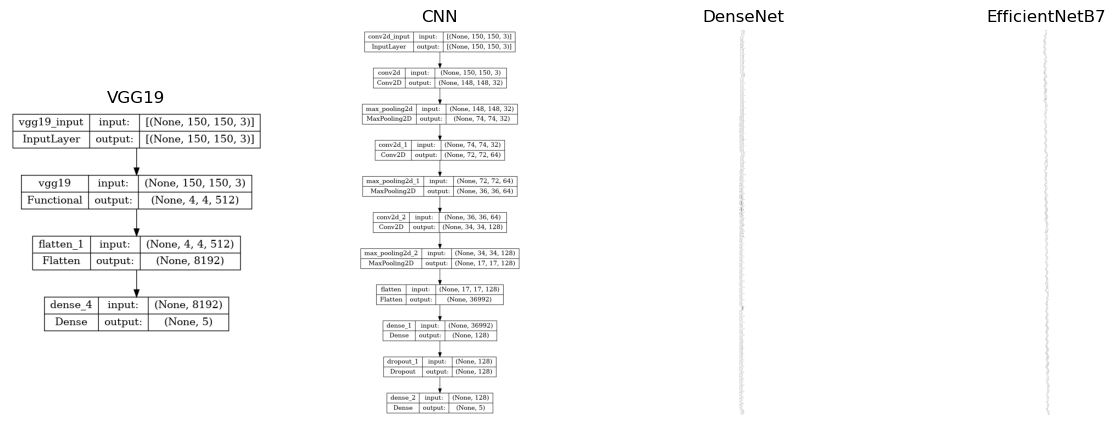

In [76]:
fig, axs = plt.subplots(1, 4, figsize=(15, 5))
axs[0].imshow(plt.imread('/kaggle/working/vgg_model.png'))
axs[1].imshow(plt.imread('/kaggle/working/cnn_model.png'))
axs[2].imshow(plt.imread('/kaggle/working/densenet_model.png'))
axs[3].imshow(plt.imread('/kaggle/working/efficientnetb7_model.png'))
axs[0].axis('off')
axs[1].axis('off')
axs[2].axis('off')
axs[3].axis('off')
axs[0].set_title('VGG19')
axs[1].set_title('CNN')
axs[2].set_title('DenseNet')
axs[3].set_title('EfficientNetB7')
plt.show()

In [77]:
!pip install visualkeras
import visualkeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 989.8/989.8 kB 20.1 MB/s eta 0:00:0000:01


In [78]:
visualkeras.layered_view(model2, legend=True)

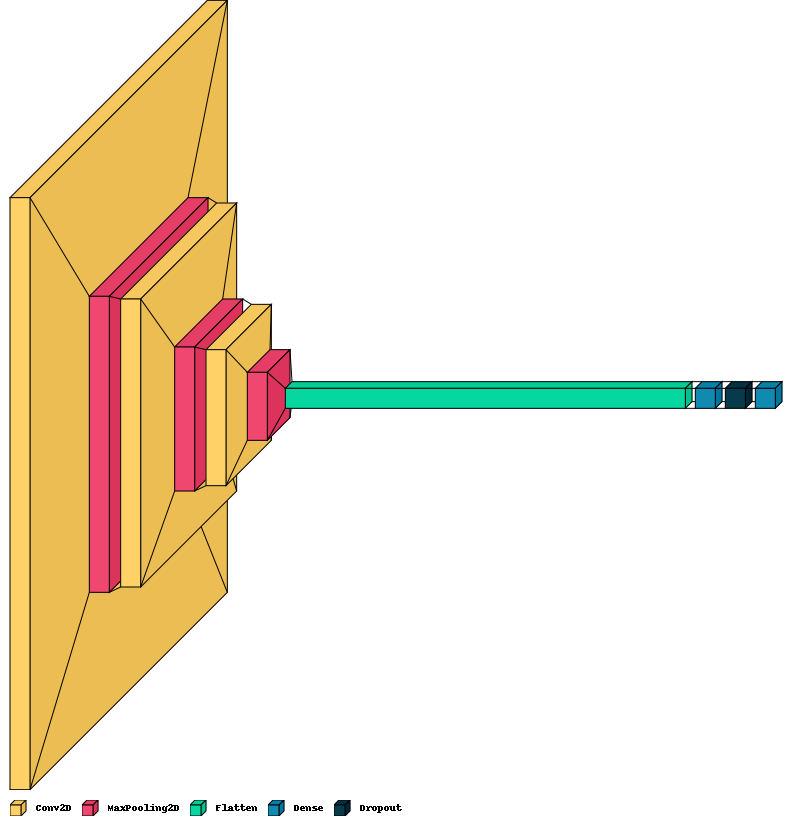

In [79]:
visualkeras.layered_view(model1, legend=True)

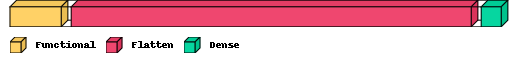

In [80]:
visualkeras.layered_view(model3, legend=True)

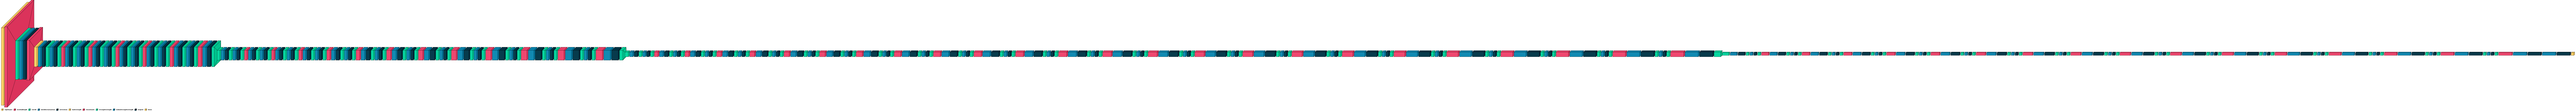

In [81]:
visualkeras.layered_view(model, legend=True)

In [82]:
scores  = model.evaluate(xtest, ytest, verbose=1)
scores1 = model1.evaluate(xtest, ytest, verbose=1)
scores2 = model2.evaluate(xtest, ytest, verbose=1)
scores3 = model3.evaluate(xtest, ytest, verbose=1)


177/177 [==============================] - 8s 40ms/step - loss: 2.7220 - accuracy: 0.9657 - precision: 0.9155 - recall: 0.9127 - auc: 0.9719


## Densenet 

In [83]:
precision = scores[0]
f1_score = scores[1]
recall = scores[2]
accuracy = scores[3]

## CNN 

In [84]:
precision1 = scores1[0]
f1_score1 = scores1[1]
recall1 = scores1[2]
accuracy1 = scores1[3]

## Efficient Net B7 

In [85]:
precision2 = scores2[0]
f1_score2 = scores2[1]
recall2 = scores2[2]
accuracy2 = scores2[3]

## VGG 19 

In [86]:
precision3 = scores3[0]
f1_score3 = scores3[1]
recall3 = scores3[2]
accuracy3 = scores3[3]

In [87]:
import pandas as pd

eval_df = pd.DataFrame(columns=['Model','Precision', 'F1 Score', 'Recall', 'Accuracy'])


In [88]:
eval_df = eval_df.append({'Model' : 'Densenet', 'Precision': precision, 'F1 Score': f1_score, 'Recall': recall, 'Accuracy': accuracy}, ignore_index=True)
eval_df = eval_df.append({'Model' : 'CNN', 'Precision': precision1, 'F1 Score': f1_score1, 'Recall': recall1, 'Accuracy': accuracy1}, ignore_index=True)
eval_df = eval_df.append({'Model' : 'Efficient Net B7', 'Precision': precision2, 'F1 Score': f1_score2, 'Recall': recall2, 'Accuracy': accuracy2}, ignore_index=True)
eval_df = eval_df.append({'Model' : 'VGG 19', 'Precision': precision3, 'F1 Score': f1_score3, 'Recall': recall3, 'Accuracy': accuracy3}, ignore_index=True)


In [1]:
eval_df

NameError: name 'eval_df' is not defined

In [90]:
import csv
eval_df.to_csv('comparison_metrics.csv', index=False)

In [ ]:
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Average
model_1 = load_model(model_1_path)
model_1 = Model(inputs=model_1.inputs,
                outputs=model_1.outputs,
                name='name_of_model_1')
model_2 = load_model(model_2_path)
model_2 = Model(inputs=model_2.inputs,
                outputs=model_2.outputs,
                name='name_of_model_2')
model_3 = load_model(model_3_path)
model_3 = Model(inputs=model_3.inputs,
                outputs=model_2.outputs,
                name='name_of_model_3')
model_4 = load_model(model_4_path)
model_4 = Model(inputs=model_4.inputs,
                outputs=model_4.outputs,
                name='name_of_model_4')
models = [model_1, model_2, model_3, model_4]
model_input = Input(shape=(image_width, image_height, 3))
model_outputs = [model(model_input) for model in models]
ensemble_output = Average()(model_outputs)
ensemble_model = Model(inputs=model_input, outputs=ensemble_output, name='ensemble')